In [1]:

import geopandas
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point, Polygon
import numpy as np
import googlemaps
from datetime import datetime
plt.rcParams["figure.figsize"] = [8,6]


# The file here looks at all California Dept of Fires (CDF) data from 2020 onwards. Polygons are thus mostly limited to California.
fires = GeoDataFrame.from_file('./Interagency_Fire_Perimeter_History_-_All_Years (2)/InteragencyFirePerimeterHistory.shp')

# Here's how the data is looking like, for reference.
fires.head(10)

,FID,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,...,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,GPS Ground,20200623,None,1,None,None,2020,00013212,...,None,Wildfire,109.602501,None,CalFire FRAP,CDF,2020,0.035733,0.000046,"POLYGON ((-121.34840 38.88999, -121.34835 38.8..."
1,2,2,GPS Ground,20200604,None,2,None,None,2020,00011799,...,None,Wildfire,685.585022,None,CalFire FRAP,CDF,2020,0.101178,0.000288,"POLYGON ((-121.35275 38.82038, -121.35267 38.8..."
2,3,3,GPS Ground,20200301,None,3,None,None,2020,00018493,...,None,Wildfire,27.300480,None,CalFire FRAP,CDF,2020,0.017450,0.000011,"POLYGON ((-121.33333 38.84558, -121.33311 38.8..."
3,4,4,GPS Ground,20200401,None,4,None,None,2020,00007619,...,None,Wildfire,12.931550,None,CalFire FRAP,CDF,2020,0.016557,0.000005,"POLYGON ((-121.27317 38.96308, -121.27304 38.9..."
4,5,5,GPS Ground,20200419,None,5,None,None,2020,00008471,...,None,Wildfire,10.315960,None,CalFire FRAP,CDF,2020,0.010920,0.000004,"POLYGON ((-121.30065 39.48714, -121.30041 39.4..."
5,6,6,GPS Ground,20200705,None,6,None,None,2020,00014858,...,None,Wildfire,36.701931,None,CalFire FRAP,CDF,2020,0.024267,0.000015,"POLYGON ((-121.38238 38.72933, -121.38241 38.7..."
6,8,8,GPS Ground,20200712,None,8,None,None,2020,00015275,...,None,Wildfire,10.102210,None,CalFire FRAP,CDF,2020,0.010780,0.000004,"POLYGON ((-121.30435 39.13366, -121.30435 39.1..."
7,9,9,GPS Ground,20200311,None,9,None,None,2020,00006064,...,None,Wildfire,33.973888,None,CalFire FRAP,CDF,2020,0.019102,0.000014,"POLYGON ((-121.31667 39.40193, -121.31655 39.4..."
8,10,10,Infrared,20201013,None,10,None,None,2020,00021423,...,None,Wildfire,1309.089966,None,CalFire FRAP,CDF,2020,0.121501,0.000554,"POLYGON ((-121.33878 39.38178, -121.33875 39.3..."
9,11,11,GPS Ground,20200706,None,11,None,None,2020,00015012,...,None,Wildfire,194.660294,None,CalFire FRAP,CDF,2020,0.058534,0.000082,"POLYGON ((-121.41211 38.73371, -121.41211 38.7..."


<AxesSubplot:>

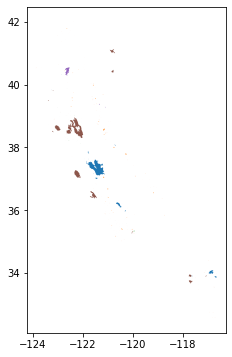

In [2]:
# FID looks like just the row numbers given after the filtering done on the dept end - nothing useful 
# Object ID may take into account the fact that we have filtered the data (some get skipped here and there).
fires = fires.set_index('FID')
fires = fires.sort_index()

# Plot and color by map_method. In other words, provide different colors for different classifications (e.g. blue for GPS Ground, red for Infrared)
# Not really needed, but interesting to see, and we can use this later in our analysis if needed.
fires.plot(column = 'MAP_METHOD')


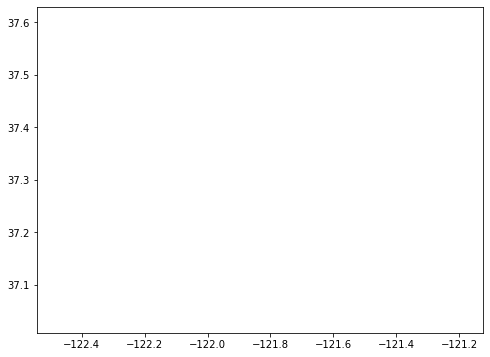

In [3]:

# Just some example bounds, can modify later
boundy1, boundx1 = 37.008438, -122.543177
boundy2, boundx2 = 37.629911, -121.124852


plt.gca().set_xlim([boundx1, boundx2])
plt.gca().set_ylim([boundy1, boundy2])

# make a grid of latitude-longitude values
xmin, xmax, ymin, ymax = boundx1, boundx2, boundy1, boundy2
xx, yy = np.meshgrid(np.linspace(xmin,xmax,50), np.linspace(ymin,ymax,50))
xc = xx.flatten()
yc = yy.flatten()

# This is setting up our zoomed in version of the map we are interested in.
# In this case, the coordinates provided in the long and lat limits (xlim, ylim)

<AxesSubplot:>

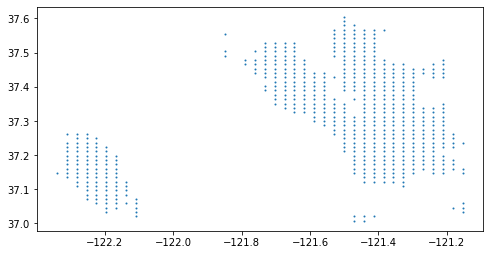

In [4]:
# Now convert these points to geo-data - may take a few minutes to do at most.
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
in_map =  np.array([pts.within(geom) for geom in fires.geometry]).sum(axis=0)
pts = GeoSeries([val for pos,val in enumerate(pts) if in_map[pos]])

pts.plot(markersize=1)

# We now have the points.

In [5]:
# (Reformat strings if needed to another type than the one given below - format rn is "Lat,Long")
coords = []
for n, point in enumerate(pts):
    coords += [','.join(__ for __ in _.strip().split(' ')[::-1]) for _ in str(point).split('(')[1].split(')')[0].split(',')]

# coords has the final answers we are looking for.

In [6]:
# Just to show that coords has only the filtered coordinates.
print(coords[:14])

['37.008438,-121.4721968979592', '37.008438,-121.4432514897959', '37.02112112244897,-122.108995877551', '37.02112112244897,-121.4721968979592', '37.02112112244897,-121.4432514897959', '37.02112112244897,-121.4143060816327', '37.03380424489796,-122.1958321020408', '37.03380424489796,-122.108995877551', '37.03380424489796,-121.1537974081633', '37.04648736734693,-122.1958321020408', '37.04648736734693,-122.1668866938776', '37.04648736734693,-122.108995877551', '37.04648736734693,-121.1827428163265', '37.04648736734693,-121.1537974081633']


In [7]:
print(len(coords))

541


In [8]:
print(coords)

['37.008438,-121.4721968979592', '37.008438,-121.4432514897959', '37.02112112244897,-122.108995877551', '37.02112112244897,-121.4721968979592', '37.02112112244897,-121.4432514897959', '37.02112112244897,-121.4143060816327', '37.03380424489796,-122.1958321020408', '37.03380424489796,-122.108995877551', '37.03380424489796,-121.1537974081633', '37.04648736734693,-122.1958321020408', '37.04648736734693,-122.1668866938776', '37.04648736734693,-122.108995877551', '37.04648736734693,-121.1827428163265', '37.04648736734693,-121.1537974081633', '37.05917048979592,-122.2247775102041', '37.05917048979592,-122.1958321020408', '37.05917048979592,-122.1668866938776', '37.05917048979592,-122.1379412857143', '37.05917048979592,-122.108995877551', '37.05917048979592,-121.1537974081633', '37.07185361224489,-122.2537229183673', '37.07185361224489,-122.2247775102041', '37.07185361224489,-122.1958321020408', '37.07185361224489,-122.1668866938776', '37.07185361224489,-122.108995877551', '37.08453673469388,-